# Imports:

In [1]:
import numpy as np
import GEOMODEL as GEOMODEL
import Noise as BSNoise
import matplotlib.pyplot as plt
import matplotlib
import scienceplots
from cycler import cycler
data = np.load('GEO_F_norm_100000_05.npz')
data2 = np.load('GEO_F_rms_100000_05.npz')
frequencies = np.logspace(0,5,100000)

# Noise Budget Code:

In [2]:
def compute_tF():
    
    # Create new adjusted model
    new_model = GEOMODEL.adjust_model()
    
    # Create Simulation that injects a gravitational wave over a range of frequencies of new model
    new_sim = new_model.deepcopy()
    new_sim.parse(
        f"""
        dof strain sy.dofs.h -1 sy2.dofs.h -1 sx.dofs.h +1 sx2.dofs.h +1
        readout_dc trans_sb optical_node=FI.p3.o
        frequency_response(logspace(0, 5, 100000), [strain.AC.i], [trans_sb.DC.o])
        """)
    
    # Run the new Simulation
    new_sim_run = new_sim.run()
    
    transferFunction = (np.abs(new_sim_run['trans_sb.DC.o','strain.AC.i'])*data2['F_rms'])/data['Fp_norm']
    
    # Return abs value of array of new data
    return transferFunction

In [3]:
def compute_ztF():
    
    # Create new adjusted model
    new_model2 = GEOMODEL.adjust_model()
    
    # Create Simulation that injects a gravitational wave over a range of frequencies of new model
    newer_sim = new_model2.deepcopy()
    newer_sim.parse(
        f"""
        readout_dc trans_sb2 optical_node=FI.p3.o
        frequency_response(logspace(0, 5, 100000), [my.mech.z, bsy.mech.z, mx.mech.z, bsx.mech.z, BS.mech.z], [trans_sb2.DC.o])
        """)
    
    # Run the new Simulation
    newer_sim_run = newer_sim.run()
    
    # Return abs value of array of new data
    return np.abs(newer_sim_run['trans_sb2.DC.o','BS.mech.z']/np.sqrt(2)), np.abs(newer_sim_run['trans_sb2.DC.o','my.mech.z']), np.abs(newer_sim_run['trans_sb2.DC.o','bsy.mech.z']), np.abs(newer_sim_run['trans_sb2.DC.o','mx.mech.z']), np.abs(newer_sim_run['trans_sb2.DC.o','bsx.mech.z'])

In [4]:
def noise_curve():
    
    # Create new adjusted model
    newModel3 = GEOMODEL.adjust_model()
    
    # Create Simulation that injects a gravitational wave over a range of frequencies of new model
    
    new_sim_noise = newModel3.deepcopy()
    new_sim_noise.parse(
        f"""
        sgen strain1 sy.h -1
        sgen strain2 sy2.h -1
        sgen strain3 sx.h +1
        sgen strain4 sx2.h +1
        
        # Create noise detectors
        qnoised quantum_nsr FI.p3.o nsr=true
        """)
    
    #Run simulation to get frequency dependent squeezing
    sol_opt_sqz = new_sim_noise.run("xaxis(fsig, log, 1, 1e5, 999, pre_step=minimize(quantum_nsr, sq1.angle))")

    # Get list of squeezing angles calcualed from simulation
    opt_angle = sol_opt_sqz["pre_step", "minimize"].x

    # Get index of lowest possible asd value from simulation
    i = np.argmin(abs(sol_opt_sqz['quantum_nsr']))

    # Set optimal squeezing angle to be the squeezing angle at the index of the lowest possible asd value
    hf_angle = opt_angle[i][0]

    #Assign model to have that squeezing angle and run quantum noise simulation again, but now it is frequency independent and catered for that frequency
    new_sim_noise.sq1.angle = hf_angle
    new_sim_noise.parse(
        f"""
        # Create noise detectors
        qnoised Quantum_noise FI.p3.o nsr=false
        
        # Sweep across frequencies
        xaxis(fsig.f, log, 1, 1e5, 99999)
        """)
    
    # Create Simulation that modulates the amplitude of the laser
    second_sim_noise = newModel3.deepcopy()
    second_sim_noise.parse(
        f"""
        dof ampNoise laser.dofs.amp +1
        readout_dc trans_sb optical_node=FI.p3.o
        frequency_response(logspace(0, 5, 100000), [ampNoise.AC.i], [trans_sb.DC.o])
        """)
    
    # Create Simulation that modulates the phase of the laser
    third_sim_noise = newModel3.deepcopy()
    third_sim_noise.parse(
        f"""
        dof freqNoise laser.dofs.frq +1
        readout_dc trans_sb optical_node=FI.p3.o
        frequency_response(logspace(0, 5, 100000), [freqNoise.AC.i], [trans_sb.DC.o])
        """)
    
    # Run new simulation
    new_sim_noise_run = new_sim_noise.run()
    second_sim_noise_run = second_sim_noise.run()
    third_sim_noise_run = third_sim_noise.run()
    
    # Calculate total quantum noise
    quantum_noise = np.abs(new_sim_noise_run['Quantum_noise'])
    
    # Calculate other noises (laser amplitude, laser frequency, and possibly dark noise)
    laserAmp_noise = (1.5*(10**-7))*(1/frequencies)*np.abs(second_sim_noise_run['trans_sb.DC.o','ampNoise.AC.i'])
    laserFreq_noise = np.sqrt((2*(3e8)*(6.626e-34))/(newModel3.laser.P*(1064e-9)))*np.pi*frequencies*np.abs(third_sim_noise_run['trans_sb.DC.o','freqNoise.AC.i'])
    
    
    # If you want to view the component tree of the model, uncomment below:
    # print(new_sim_noise.component_tree())
    
    # Return abs value of array of individual noise curves
    return quantum_noise, laserAmp_noise, laserFreq_noise

In [5]:
def NSR(transfer_Function='', quantum_noise='', laserAmp_noise='', laserFreq_noise=''):

    # Create Noise to Signal Ratio (NSR) array from input transfer function and noise curve
    quantum_nsr = quantum_noise/transfer_Function
    laserAmp_nsr = laserAmp_noise/transfer_Function
    laserFreq_nsr = laserFreq_noise/transfer_Function
    
    # Extract different z motion transfer functions
    beamsplitter_tF, my_tF, bsy_tF, mx_tF, bsx_tF = compute_ztF()
    
    # Create Noise to Signal Ratio (NSR) array for displacement noises taken from analytical functions found in literature
    seismic_noise1 = (((10**-7) * (1/(frequencies**2)))*(((0.5**2)/(frequencies**2))**3)) * (my_tF/compute_tF())
    seismic_noise2 = (((10**-7) * (1/(frequencies**2)))*(((0.5**2)/(frequencies**2))**3)) * (bsy_tF/compute_tF())
    seismic_noise3 = (((10**-7) * (1/(frequencies**2)))*(((0.5**2)/(frequencies**2))**3)) * (mx_tF/compute_tF())
    seismic_noise4 = (((10**-7) * (1/(frequencies**2)))*(((0.5**2)/(frequencies**2))**3)) * (bsx_tF/compute_tF())
    seismic_noise = np.sqrt(seismic_noise1**2 + seismic_noise2**2 + seismic_noise3**2 + seismic_noise4**2)
    
    TM_coating_BM_noise1 = BSNoise.TMcoatingBM()*(my_tF/compute_tF())*np.sqrt(2/3)
    TM_coating_BM_noise2 = BSNoise.TMcoatingBM()*(bsy_tF/compute_tF())
    TM_coating_BM_noise3 = BSNoise.TMcoatingBM()*(mx_tF/compute_tF())*np.sqrt(2/3)
    TM_coating_BM_noise4 = BSNoise.TMcoatingBM()*(bsx_tF/compute_tF())
    TM_coating_BM_noise = np.sqrt(TM_coating_BM_noise1**2 + TM_coating_BM_noise2**2 + TM_coating_BM_noise3**2 + TM_coating_BM_noise4**2)
    
    TM_coating_TE_noise1 = BSNoise.TMcoatingTE()*(my_tF/compute_tF())*np.sqrt(2/3)
    TM_coating_TE_noise2 = BSNoise.TMcoatingTE()*(bsy_tF/compute_tF())
    TM_coating_TE_noise3 = BSNoise.TMcoatingTE()*(mx_tF/compute_tF())*np.sqrt(2/3)
    TM_coating_TE_noise4 = BSNoise.TMcoatingTE()*(bsx_tF/compute_tF())
    TM_coating_TE_noise = np.sqrt(TM_coating_TE_noise1**2 + TM_coating_TE_noise2**2 + TM_coating_TE_noise3**2 + TM_coating_TE_noise4**2)
    
    TM_substrate_BM_noise1 = BSNoise.TMsubstrateBM()*(my_tF/compute_tF())
    TM_substrate_BM_noise2 = BSNoise.TMsubstrateBM()*(bsy_tF/compute_tF())
    TM_substrate_BM_noise3 = BSNoise.TMsubstrateBM()*(mx_tF/compute_tF())
    TM_substrate_BM_noise4 = BSNoise.TMsubstrateBM()*(bsx_tF/compute_tF())
    TM_substrate_BM_noise = np.sqrt(TM_substrate_BM_noise1**2 + TM_substrate_BM_noise2**2 + TM_substrate_BM_noise3**2 + TM_substrate_BM_noise4**2)
    
    TM_substrate_TE_noise1  = BSNoise.ETMsubstrateTE()*(my_tF/compute_tF()) #different function for nonfolding end mirrors since it is not just a factor of sqrt(2/3) difference
    TM_substrate_TE_noise2  = BSNoise.TMsubstrateTE()*(bsy_tF/compute_tF())
    TM_substrate_TE_noise3  = BSNoise.ETMsubstrateTE()*(mx_tF/compute_tF())
    TM_substrate_TE_noise4  = BSNoise.TMsubstrateTE()*(bsx_tF/compute_tF())
    TM_substrate_TE_noise = np.sqrt(TM_substrate_TE_noise1**2 + TM_substrate_TE_noise2**2 + TM_substrate_TE_noise3**2 + TM_substrate_TE_noise4**2)
    
    TM_pend_VM_noise1 = BSNoise.violinModeTE()*(my_tF/compute_tF())
    TM_pend_VM_noise2 = BSNoise.violinModeTE()*(bsy_tF/compute_tF())
    TM_pend_VM_noise3 = BSNoise.violinModeTE()*(mx_tF/compute_tF())
    TM_pend_VM_noise4 = BSNoise.violinModeTE()*(bsx_tF/compute_tF())
    TM_pend_VM_noise = np.sqrt(TM_pend_VM_noise1**2 + TM_pend_VM_noise2**2 + TM_pend_VM_noise3**2 + TM_pend_VM_noise4**2)
    
    TM_pend_PM_noise1 = BSNoise.pendulumModeTE()*(my_tF/compute_tF())
    TM_pend_PM_noise2 = BSNoise.pendulumModeTE()*(bsy_tF/compute_tF())
    TM_pend_PM_noise3 = BSNoise.pendulumModeTE()*(mx_tF/compute_tF())
    TM_pend_PM_noise4 = BSNoise.pendulumModeTE()*(bsx_tF/compute_tF())
    TM_pend_PM_noise = np.sqrt(TM_pend_PM_noise1**2 + TM_pend_PM_noise2**2 + TM_pend_PM_noise3**2 + TM_pend_PM_noise4**2)
    
    TM_suspension_noise = np.sqrt(TM_pend_VM_noise**2 + TM_pend_PM_noise**2)
    
    BS_substrate_BM_noise = BSNoise.BSsubstrateBM() * (beamsplitter_tF/compute_tF())
    
    BS_coating_BM_noise = BSNoise.BScoatingBM() * (beamsplitter_tF/compute_tF())
    
    BS_substrate_TR_noise = BSNoise.BSthermorefractive() * (beamsplitter_tF/compute_tF())
    
    total_NSR = np.sqrt(quantum_nsr**2 + seismic_noise**2 + TM_coating_BM_noise**2 + TM_coating_TE_noise**2 + TM_substrate_BM_noise**2 + TM_substrate_TE_noise**2 + TM_suspension_noise**2 + BS_substrate_BM_noise**2 + BS_coating_BM_noise**2 + BS_substrate_TR_noise**2 + laserAmp_nsr**2 + laserFreq_nsr**2)
    
    #return total_NSR, and individual NSRs
    return total_NSR, quantum_nsr, seismic_noise, TM_coating_BM_noise, TM_coating_TE_noise, TM_substrate_BM_noise, TM_substrate_TE_noise, TM_suspension_noise, BS_substrate_BM_noise, BS_coating_BM_noise, BS_substrate_TR_noise, laserAmp_nsr, laserFreq_nsr

In [6]:
def noiseBudget():
    
    # Function that creates a Noise Budget for the current model of GEO 600 by making a Bode Plot, noise curve, and NSR graph for all noise 
    
    # Compute Transfer function
    transfer_Function = compute_tF()
    beamsplitter_tF, my_tF, bsy_tF, mx_tF, bsx_tF = compute_ztF()
    
    # Compute Noise Curve
    quantum_noise, laserAmp_noise, laserFreq_noise = noise_curve()
    
    # Create Noise to Signal Ratio from TF and Noise Curve
    totalNSR, quantum_nsr, seismic_noise, TM_coating_BM_noise, TM_coating_TE_noise, TM_substrate_BM_noise, TM_substrate_TE_noise, TM_suspension_noise, BS_substrate_BM_noise, BS_coating_BM_noise, BS_substrate_TR_noise, laserAmp_nsr, laserFreq_nsr = NSR(transfer_Function=transfer_Function, 
    quantum_noise=quantum_noise, laserAmp_noise=laserAmp_noise, laserFreq_noise=laserFreq_noise)
    
    
    # Plot Transfer Functions, Noise Curves, and NSRs
    plot_tF(transfer_Function)
    plot_nC(quantum_noise, laserAmp_noise, laserFreq_noise)
    plot_NSR(totalNSR=totalNSR, quantum_nsr=quantum_nsr, seismic_noise=seismic_noise, TM_coating_BM_noise=TM_coating_BM_noise, TM_coating_TE_noise=TM_coating_TE_noise, 
             TM_substrate_BM_noise=TM_substrate_BM_noise, TM_substrate_TE_noise=TM_substrate_TE_noise, TM_suspension_noise=TM_suspension_noise, BS_substrate_BM_noise=BS_substrate_BM_noise, BS_coating_BM_noise=BS_coating_BM_noise, 
             BS_substrate_TR_noise=BS_substrate_TR_noise, laserAmp_nsr=laserAmp_nsr, laserFreq_nsr=laserFreq_nsr)
    
    return totalNSR

# Graphing Code:

In [7]:
def plot_tF(tF):
    # Plot the transfer functions by looping through the input TF list and plotting every array value
    %matplotlib widget
    plt.figure(figsize=(10, 6))
    plt.loglog(frequencies, tF)
    plt.title('GEO600 Bode Plot')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude [w]')
    plt.grid(True)
    plt.show()
    
    return

In [8]:
def plot_nC(quantum_noise='', laserAmp_noise='', laserFreq_noise=''):
    # Plot the Noise Curves by looping through the input noise curve list and plotting every array value
    %matplotlib widget
    plt.figure(figsize=(10, 6))
    plt.loglog(frequencies, quantum_noise, label='Quantum Noise')
    plt.loglog(frequencies, laserAmp_noise, label='Laser Amplitude Noise')
    plt.loglog(frequencies, laserFreq_noise, label='Laser Frequency Noise')
    plt.title('GEO600 Noise Curve')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel(r'ASD [$\frac{w}{\sqrt{Hz}}$]')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return

In [9]:
def plot_NSR(totalNSR='', quantum_nsr='', seismic_noise='', TM_coating_BM_noise='', TM_coating_TE_noise='', TM_substrate_BM_noise='', TM_substrate_TE_noise='', TM_suspension_noise='', BS_substrate_BM_noise='', BS_coating_BM_noise='', BS_substrate_TR_noise='', laserAmp_nsr='', laserFreq_nsr=''):
    
    # Plot the NSRs by looping through the input NSR list and plotting every array value
    
    %matplotlib widget
    # Set font properties globally
    plt.style.use(['science','ieee','notebook'])
    plt.rcParams.update({'figure.dpi': 150})
    plt.rcParams['axes.prop_cycle'] = cycler('color', ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF', '#9A0EEA'])
    plt.rcParams.update({'font.serif': 'serif', 'font.family' : 'DeJavu Serif'}) 
    plt.rcParams.update({
        'font.size': 23,
        'axes.labelsize': 23,
        'xtick.labelsize': 20,
        'ytick.labelsize': 20,
        'legend.fontsize': 17
    })
    
    plt.figure(figsize=(12, 9))
    plt.plot(frequencies, quantum_nsr, label='Quantum')#, linewidth=2
    plt.plot(frequencies, laserAmp_nsr, label='Laser amplitude', color='r')
    plt.plot(frequencies, laserFreq_nsr, label='Laser frequency', color='#fec615')
    plt.plot(frequencies, seismic_noise, label='Seismic', color='#af6f09')
    plt.plot(frequencies, TM_coating_BM_noise, label='Coating BM', color='cyan')
    plt.plot(frequencies, TM_coating_TE_noise, label='Coating TE', color='lightskyblue')
    plt.plot(frequencies, TM_substrate_BM_noise, label='Substrate BM', color='#61e160')
    plt.plot(frequencies, TM_substrate_TE_noise, label='Substrate TE', color='#02c14d')
    plt.plot(frequencies, TM_suspension_noise, label='Suspension thermal', color='tab:orange')
    plt.plot(frequencies, BS_substrate_BM_noise, label='BS substrate BM', color='#e4cbff')
    plt.plot(frequencies, BS_substrate_TR_noise, label='BS substrate TR', color='violet')
    plt.plot(frequencies, BS_coating_BM_noise, label='BS coating BM', color='mediumslateblue')
    plt.plot(frequencies, totalNSR, 'k--', label='Total sensitivity')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which='major')#linestyle='-', linewidth=0.75

    # Enable minor ticks without grid lines
    plt.minorticks_on()  # Turn on minor ticks
    plt.grid(False, which='minor')  # Disable grid lines for minor ticks
    
    plt.tick_params(which='both', direction = 'out', top=False, left=True, right=False, bottom=True)#, labelsize=18
    plt.tick_params(axis='both', which='major')#, length=6, width=1
    plt.tick_params(axis='both', which='minor')#, length=3, width=1
    #plt.title('GEO600', fontsize=fontsize)
    plt.xlabel('Frequency (Hz)')#, fontsize=fontsize
    plt.ylabel(r'ASD ($1/\sqrt{\text{Hz}}$)')#, fontsize=fontsize
    plt.ylim(1e-25, 1e-19)
    plt.xlim(2,1e5)
    plt.legend(frameon=True, ncol=2, facecolor='white', loc='upper right') # fontsize=14,
    # plt.savefig('GEO600 Anti-Tuned Noise Budget.pdf',format='pdf', dpi=300)
    plt.show()
    return

# Run Code:

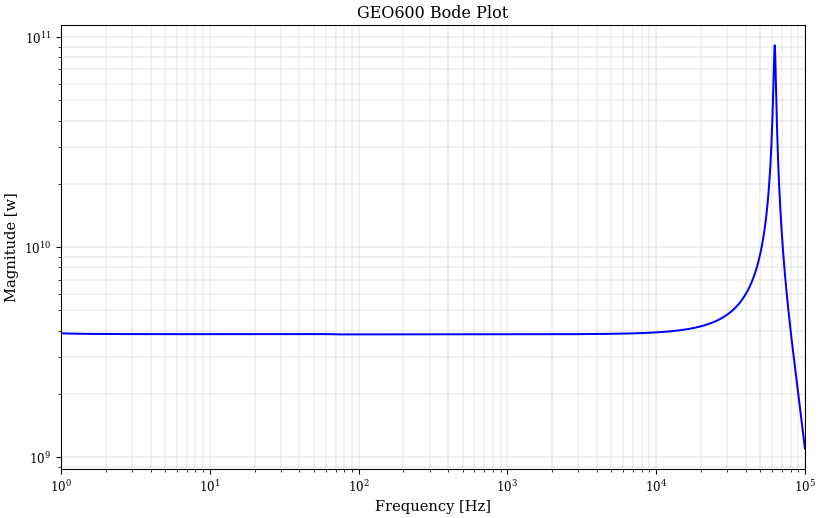

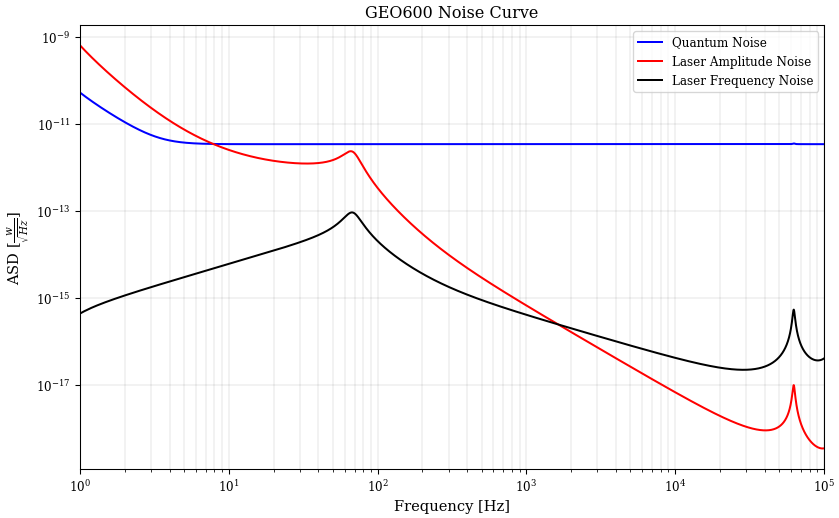

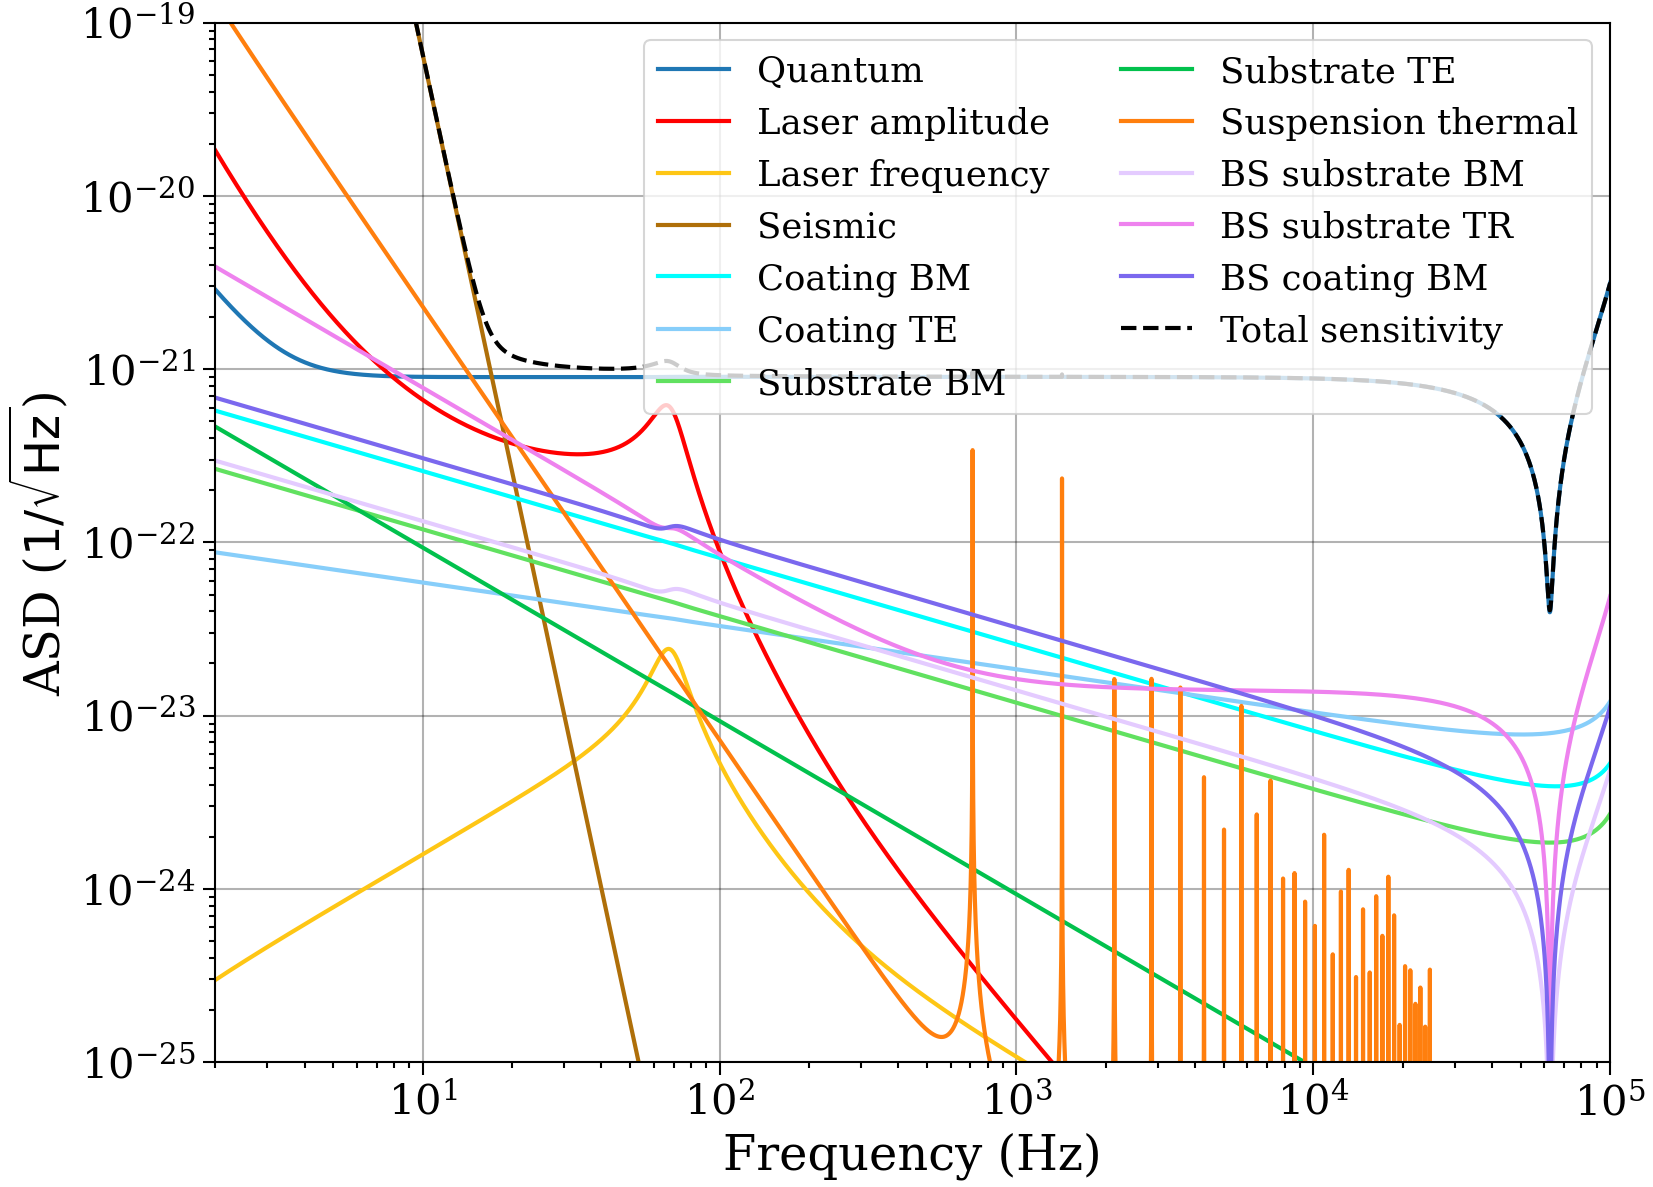

In [10]:
total_NSR = noiseBudget()

# Create Zip files:

In [11]:
# Create and add to zip file:

#np.savez('IntASD05.npz', freq05mil=np.logspace(0,5,1000000), GEO600=total_NSR)

'''
with np.load('IntASD05.npz') as data:
    # Convert the existing data to a dictionary to modify it
    existing_data = dict(data.items())
    
    # Assume new_ASD is the new ASD array you want to add
    GEO600_3W_antituned = noiseBudget()  # Replace with your method of obtaining the new ASD array
    
    # Append the new ASD array under a different key, e.g., 'ASD2'
    existing_data['GEO600 3W Anti-tuned'] = GEO600_3W_antituned
    
    # Save the updated data back to the .npz file
    np.savez('IntASD05.npz', **existing_data)
'''

"\nwith np.load('IntASD05.npz') as data:\n    # Convert the existing data to a dictionary to modify it\n    existing_data = dict(data.items())\n    \n    # Assume new_ASD is the new ASD array you want to add\n    GEO600_3W_antituned = noiseBudget()  # Replace with your method of obtaining the new ASD array\n    \n    # Append the new ASD array under a different key, e.g., 'ASD2'\n    existing_data['GEO600 3W Anti-tuned'] = GEO600_3W_antituned\n    \n    # Save the updated data back to the .npz file\n    np.savez('IntASD05.npz', **existing_data)\n"